# data prepare

In [137]:
import pandas as pd

In [16]:
name_df = pd.read_csv(r"name_data\name_with_gender_data.csv")

In [135]:
name_df

,name,gender,message,BirthYear
0,丁承先,1,1940,0
1,丁昞原,1,1940,0
2,方超,1,1940,0
3,方九龍,1,1940,0
4,方大錚,1,1940,0
...,...,...,...,...
138773,程麗庭,0,1982,8
138774,許家榛,0,1979,7
138775,田崑成,1,1978,7
138776,筱欣,0,1998,11


# Few shot Classifier by ask chatgpt

In [12]:
import openai # OpenAI API
import time
openai.api_key  = ""

In [78]:
def initialize():
    initialMessage = [
        {"role": "system",
        "content": """
{\"丁承先\": {"gender":  男, "age": 80,},
\"孫玉燕\": {"gender":  女, "age": 72,},
\"賴惠玉\": {"gender":  女, "age": 45,},
\"鄭裕融\": {"gender":  男, "age": 31,},
\"曾振民\": {"gender":  男, "age": 57,},
...}
以上是人名的年齡和性別的資料的範例,  請協助我補完我輸入的中文名字的年齡與性別, 年齡的範圍是20~80, 性別是男或女,
以json格式回答, 不要作其他解釋與說明, 替每個名字給予一個最常見的數值, 現在開始"""
},
]
    return initialMessage

In [79]:
def updateMessageList(message, role, messageList):

    try:
        messageList.append({
            "role": role,
            "content": message,
        })
    except Exception as e:
        print(e)

    return messageList

def getResponse(prompt, history=[], messageList={}):

    # 將使用者輸入內容更新至訊息紀錄
    updateMessageList(prompt, 'user', messageList)

    # 與API互動並取得回應
    responseDict = openai.ChatCompletion.create(
        model='gpt-3.5-turbo',
        messages=messageList,
    )

    # 擷取回覆字串
    responseMessage = responseDict['choices'][0]['message']['content']

    # 將回覆更新至訊息紀錄
    updateMessageList(responseMessage, 'assistant', messageList)

    # 將使用者以及機器人的訊息整理為兩個串列
    userContext = [content['content']
                   for content in messageList if content['role'] == 'user']
    assistantContext = [content['content']
                        for content in messageList if content['role'] == 'assistant']

    # 利用使用者以及機器人訊息構成對話紀錄
    response = [(_user, _response) for _user, _response in zip(
        userContext[1:], assistantContext[1:])]

    # 回傳對話紀錄，由於我們使用自定義的方法進行訊息紀錄，故不需要回傳紀錄
    return response, []

In [6]:
messageList = initialize()
messageList

[{'role': 'system',
  'content': '\n{"丁承先": {"gender":  男, "age": 80,},\n"孫玉燕": {"gender":  女, "age": 72,},\n"鄭裕融": {"gender":  男, "age": 31,},\n...}\n以上是人名的年齡和性別的資料的範例,  請協助我補完我輸入的中文名字的年齡與性別,\n以json格式回答, 不要作其他解釋與說明, 替每個名字給予一個最常見的數值, 現在開始'}]

In [8]:
def get_response(sentence, messageList):
    messageList.append({
        "role": "user",
        "content": sentence,
    })
    
    # 與API互動並取得回應
    responseDict = openai.ChatCompletion.create(
        model='gpt-3.5-turbo',
        messages=messageList,
    )

    # 擷取回覆字串
    responseMessage = responseDict['choices'][0]['message']['content']
    
    return responseMessage

In [13]:
responseMessage = get_response("陳昱彤", messageList)
responseMessage

'{"陳昱彤": {"gender": "女", "age": 27}}'

In [23]:
def str_to_json(responseMessage):
    import json
    return json.loads(responseMessage)

In [ ]:
predict_result = {}
# 每階層取50個人名出來
test_df = name_df.groupby('BirthYear').apply(lambda x: x.sample(50)).reset_index(drop=True)

In [136]:
test_df

,name,gender,message,BirthYear
0,林克毅,1,1944,0
1,林文雄,1,1940,0
2,詹有為,1,1944,0
3,宣凱兒,0,1944,0
4,蔡秀繼,1,1944,0
...,...,...,...,...
695,洪正洋,1,2005,13
696,符睿妤,0,2005,13
697,李芝嫻,0,2006,13
698,黃韻嘉,0,2005,13


In [85]:
# A ver
for name in test_df['name']:
    if name in predict_result and predict_result[name] is not None:
        continue
    messageList = initialize()
    responseMessage = get_response(name, messageList)
    if "男," in responseMessage or "女," in responseMessage:    
        responseMessage = responseMessage.replace("男", "\"男\"").replace("女", "\"女\"")
    print(name, responseMessage)
    try:
        result = str_to_json(responseMessage)
        predict_result[name] = result[name]

    except:
        predict_result[name] = None
    time.sleep(6)

車和道 抱歉，請提供詳細姓名，以便我為您提供正確的回答。
向後退 請問有什麼需要幫忙的嗎？
林逼 抱歉，我無法為此名字提供年齡和性別的資訊，因為「林逼」並非合法的中文名字，也不符合常見的名字用法和稱呼規範。請提供正確的中文名字，以便我能提供正確的回答。
樂抹茶 很抱歉，樂抹茶不是一個人名，請您提供正確的人名以便補完年齡和性別的資料，謝謝！
元嘎 {"元嘎": {"gender": "男", "age": 25}}
賴姳蒨 抱歉，我無法提供賴姳蒨的年齡與性別，因為我無法從這個名字分辨出來。
陳宓楚 {"陳宓楚": {"gender": "女", "age": 25}}
鄭亦喬 {"鄭亦喬": {"gender": "女", "age": 27}}
陳椴子 {"陳椴子": {"gender": "男", "age": 40}}
廖珮君 {"廖珮君": {"gender": "女", "age": 30}}
劉功俊 {"劉功俊": {"gender": "男", "age": 35}}
洪元浩 {"洪元浩": {"gender": "男", "age": 40}}
廖琳琳 {"廖琳琳": {"gender":  "女", "age": 28}}
林恩生 {"林恩生": {"gender": "男", "age": 40}}
賴宇嬅 {"賴宇嬅": {"gender": "女", "age": 25}}
邱致升 {"邱致升": {"gender": "男", "age": 33}}
楊惠宇 {"楊惠宇": {"gender": "男", "age": 28}}
楊柏皓 {"楊柏皓": {"gender": "男", "age": 26}}
周縝曦 {"周縝曦": {"gender": "男", "age": 28}}
吳薇 {"吳薇":{"gender": "女", "age": 35}}
游至誠 {"游至誠": {"gender": "男", "age": 31}}
蔡逸明 {"蔡逸明": {"gender": "男", "age": 35}}
賴孟孟 {"賴孟孟": {"gender": "女", "age": 25}}
洪正洋 {"洪正洋": {"gender": "男", "age": 30}}
符睿妤 {"符睿妤": {"gender": "女", "age": 

# validation

In [138]:
import numpy as np
# Validation
gender_accuracy = 0
age_accuracy = 0
age_dist = 0
valid_predict = 0

male_true = 0
male_false = 0
female_true = 0
female_false = 0
# 初始化混淆矩陣
birth_year_confusion = np.zeros((14, 14))

for i, name in enumerate(predict_result):
    if predict_result[name] is None:
        continue
    valid_predict += 1
    most_gender = name_df.query(f"name == '{name}'")['gender'].mode()[0]
    avg_age = name_df.query(f"name == '{name}'")['message'].mean()
    # print(name, predict_result[name])
    if ((predict_result[name]['gender'] == "男" and most_gender == 1) or 
        (predict_result[name]['gender'] == "女" and most_gender == 0)
        ):
        gender_accuracy += 1
        if predict_result[name]['gender'] == "男":
            male_true += 1
        else:
            female_true += 1
    else:
        if predict_result[name]['gender'] == "男":
            male_false += 1
        else:
            female_false += 1

    predict_age = int(predict_result[name]['age'])
    age_interval = int((avg_age - 1945)/5)
    dis = abs(2021 - predict_age - avg_age)
    
    
    if dis < 5:
        age_accuracy += 1
    age_dist += dis
    birth_year_confusion[age_interval][int((2021 - predict_age - 1945 )/5)] += 1

print("Result")
print(f"age_accuracy: {age_accuracy/valid_predict}")
print(f"gender_accuracy: {gender_accuracy/valid_predict}")
print(f"avg_age_dist: {age_dist/valid_predict}")


Result
age_accuracy: 0.16305916305916307
gender_accuracy: 0.8802308802308803
avg_age_dist: 16.844260830390926


confusion matrix

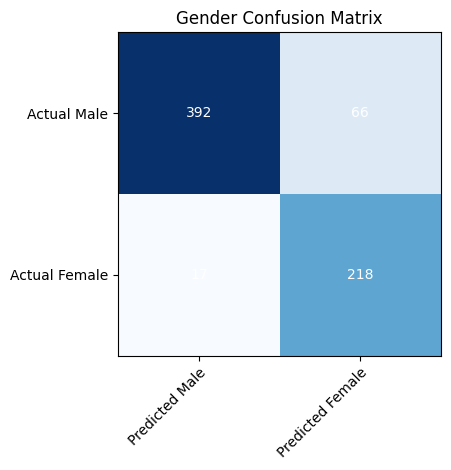

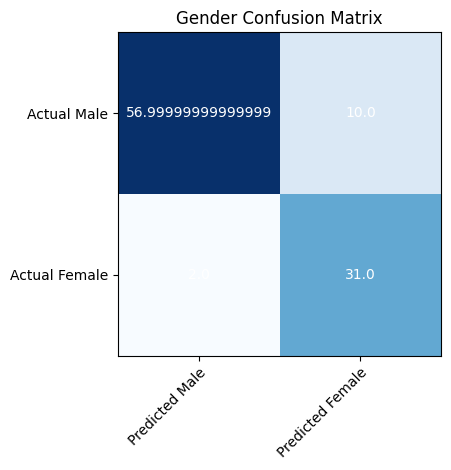

In [95]:
import matplotlib.pyplot as plt

import numpy as np

# Compute confusion matrix
def gender_confusion_matrix(male_true, male_false, female_false, female_true):
    confusion_matrix = np.array([[male_true, male_false], [female_false, female_true]])

    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='Blues')

    # Show all ticks
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))

    # Label ticks
    ax.set_xticklabels(['Predicted Male', 'Predicted Female'])
    ax.set_yticklabels(['Actual Male', 'Actual Female'])

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, confusion_matrix[i, j],
                        ha="center", va="center", color="w")

    ax.set_title("Gender Confusion Matrix")
    fig.tight_layout()
    plt.show()
    
gender_confusion_matrix(male_true, male_false, female_false, female_true)


male_true_percent = round(male_true/valid_predict, 2) * 100
male_false_percent = round(male_false/valid_predict, 2) * 100
female_false_percent = round(female_false/valid_predict, 2) * 100
female_true_percent = round(female_true/valid_predict, 2) * 100

gender_confusion_matrix(male_true_percent, male_false_percent,female_false_percent, female_true_percent)


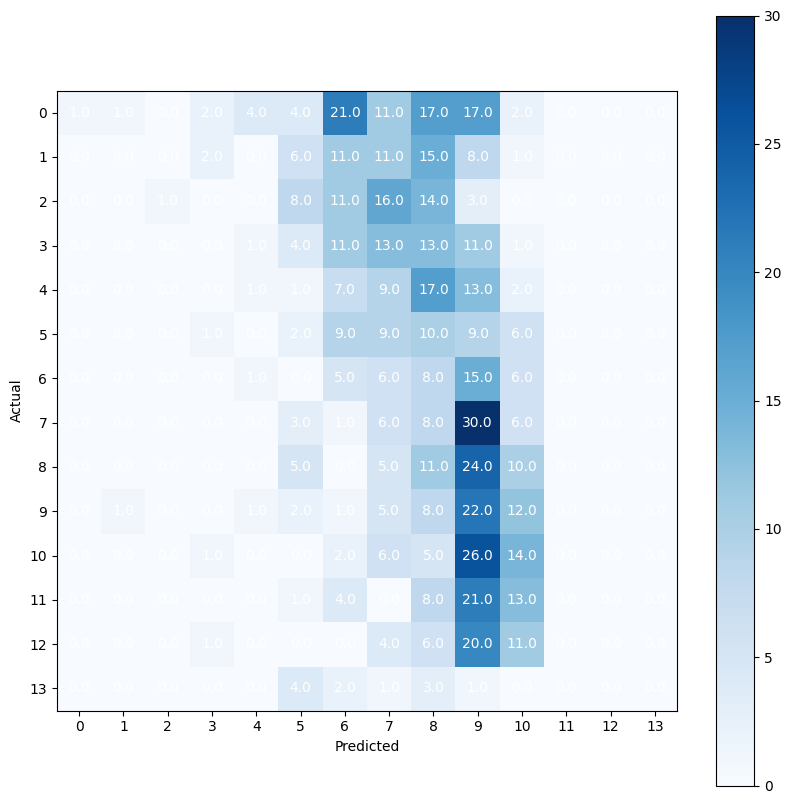

In [132]:

num_classes = len(birth_year_confusion)
# 將結果整理成矩陣形式
confusion_matrix = birth_year_confusion
# 繪製confusion matrix
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()

# 添加標籤
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 添加數值
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='white')

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()

# 結果:
## gender predict略輸於一般RFC分類器的準確率, 88% vs 93% (RFC模型), 計算成本也比較大, 
## age predict 深藍色集中在中間的7~10的垂直, 也許是因為prompt不夠好, 模型認知上注意力放在平均, 又告訴他年齡範圍, 所以就會集中在中間, 而不是靠著對年代感的名字的認知去回答

不過只是實驗看看模型的認知能力
假如搭配langchain或是其他框架, 確實能穩定批次的來回對話進行某些的工作